In [42]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
import matplotlib.pyplot as plt

In [43]:
# Подготовка данных
df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Лабы нейронки/data.xlsx")

df = df[["ХСН", "САД", "КСР", "QRS", "HCT", "PLT", "СКФ"]]
df = df.dropna()
df = df.to_numpy()

X = df[:, 1:]
y = df[:, 0]

# Разделение выборки на тестовую и обучающую
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.32, random_state=42)

# Выбор двух признаков для классификации (САД и КСР)
X_selected = X[:, [0, 3]]

Accuracy: 1.00


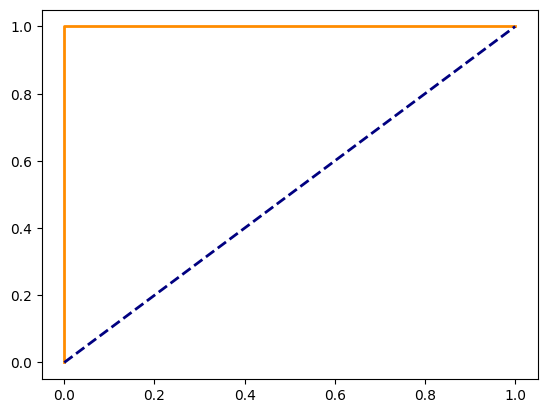

In [44]:
# Построение и обучение модели дерева решений
model = DecisionTreeClassifier()
model.fit(X_selected, y)

# Предсказание
y_pred = model.predict(X_selected)

# Расчет accuracy
accuracy = accuracy_score(y, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Построение ROC-кривой
y_prob = model.predict_proba(X_selected)[:, 1]
fpr, tpr, _ = roc_curve(y, y_prob)
roc_auc = auc(fpr, tpr)

# Визуализация ROC-кривой
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.show()


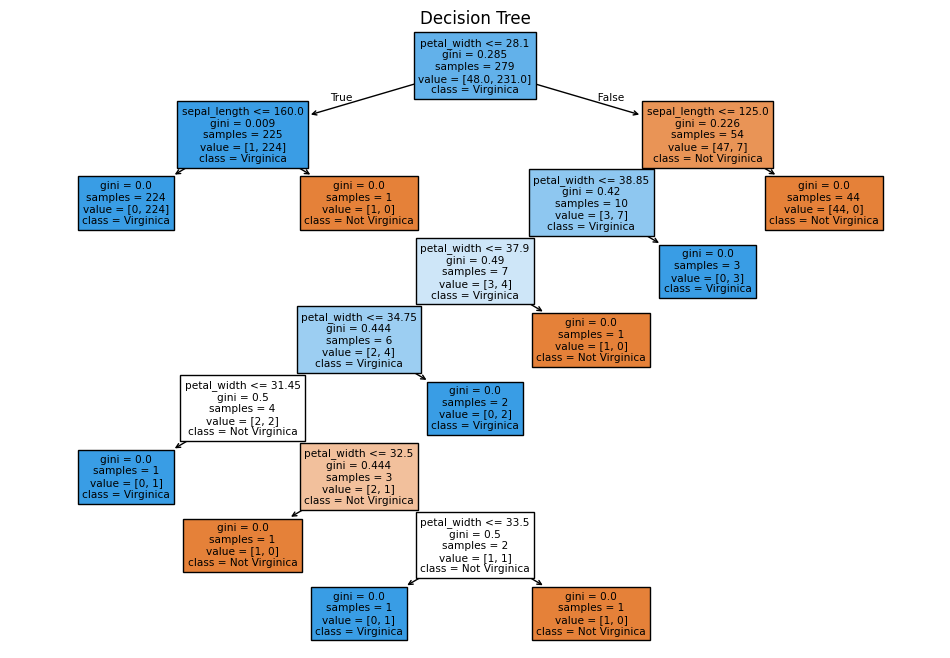

In [45]:
# Визуализация дерева решений
plt.figure(figsize=(12, 8))
plot_tree(model, filled=True, feature_names=['sepal_length', 'petal_width'], class_names=['Not Virginica', 'Virginica'])
plt.title('Decision Tree')
plt.show()

Accuracy на тестовой выборке: 1.00


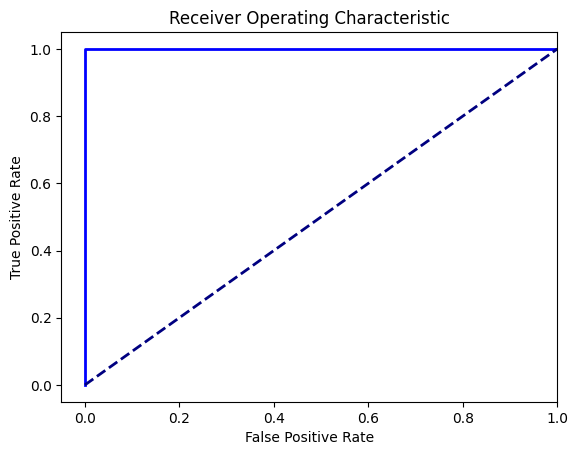

In [46]:
# Разделение датасета на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

# Построение и обучение модели дерева решений
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred_test = model.predict(X_test)

# Расчет accuracy на тестовой выборке
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f'Accuracy на тестовой выборке: {accuracy_test:.2f}')

# Построение ROC-кривой
y_prob_test = model.predict_proba(X_test)[:, 1]

fpr_test, tpr_test, _ = roc_curve(y_test, y_prob_test)
roc_auc_test = auc(fpr_test, tpr_test)

# Визуализация ROC-кривых
plt.figure()
plt.plot(fpr_test, tpr_test, color='blue', lw=2, label=f'ROC curve (test, area = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.show()

Mean Accuracy: 0.97
Mean ROC AUC: 0.94


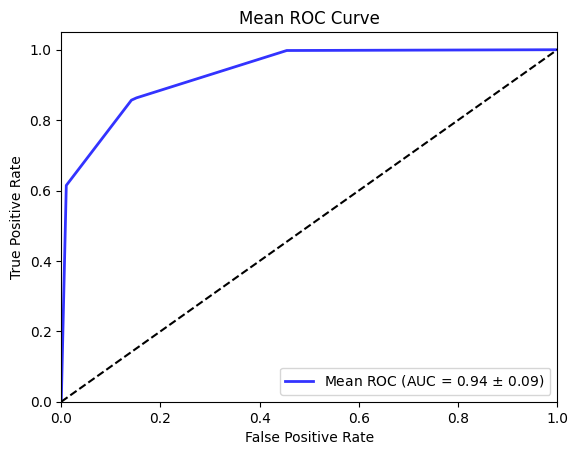

In [47]:
# Инициализация k-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Списки для хранения результатов
accuracies = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

# Обучение и оценка модели для каждой фолд
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    accuracies.append(accuracy)
    aucs.append(roc_auc)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

# Средние значения accuracy и ROC AUC
mean_accuracy = np.mean(accuracies)
mean_roc_auc = np.mean(aucs)

print(f'Mean Accuracy: {mean_accuracy:.2f}')
print(f'Mean ROC AUC: {mean_roc_auc:.2f}')

# Построение средней ROC-кривой
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean ROC Curve')
plt.legend(loc="lower right")
plt.show()


Лучшие параметры: {'criterion': 'gini', 'max_depth': 2}
Accuracy с лучшими параметрами: 0.99


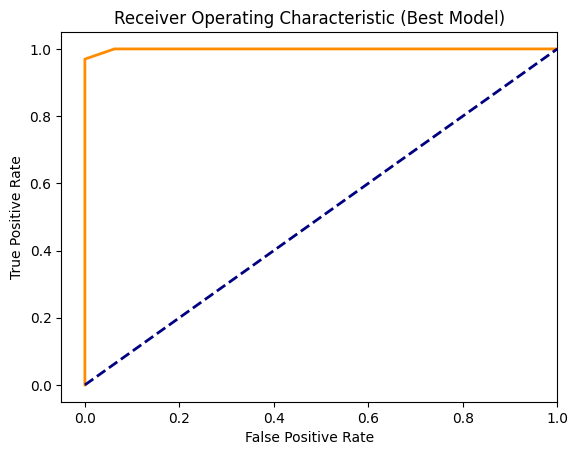

In [ ]:
# Инициализация k-Fold кросс-валидации
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Списки для хранения результатов
accuracies = []
fprs = []
tprs = []
aucs = []

# Параметры для подбора
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 4, 6, 8, 10]
}

# Подбор гиперпараметров с использованием GridSearchCV
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=kf, scoring='accuracy')
grid_search.fit(X_selected, y)

# Лучшие параметры
best_params = grid_search.best_params_
print(f'Лучшие параметры: {best_params}')

# Обучение модели с лучшими параметрами
best_model = DecisionTreeClassifier(**best_params)
best_model.fit(X_selected, y)

# Предсказание
y_pred = best_model.predict(X_selected)
y_prob = best_model.predict_proba(X_selected)[:, 1]

# Расчет accuracy
accuracy = accuracy_score(y, y_pred)
print(f'Accuracy с лучшими параметрами: {accuracy:.2f}')

# Построение ROC-кривой
fpr, tpr, _ = roc_curve(y, y_prob)
roc_auc = auc(fpr, tpr)

# Визуализация ROC-кривой
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Best Model)')
plt.show()
